In [1]:
import os
os.chdir('../../')

INFO - main.py - 2025-03-31 13:29:24,069 - Using device: cuda
INFO - main.py - 2025-03-31 13:29:24,069 - Using device: cuda
INFO - main.py - 2025-03-31 13:29:24,069 - Using device: cuda


[prepare_model] Model is ready.
/data/data/rbfsolverglq10laggrid/NFE=5,p=3,dataset=IMAGENET64.npy loaded!


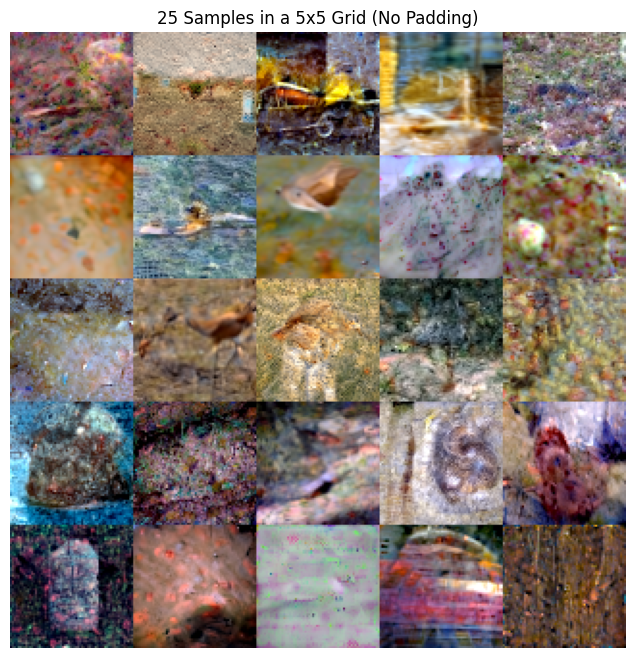

In [4]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

from main import parse_args_and_config, Diffusion
from datasets import inverse_data_transform

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.benchmark = False

###############################################################################
# 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
###############################################################################
sys.argv = [
    "main.py",
    "--config", "imagenet64.yml",  # 사용하려는 config
    "--sample",
    "--sample_type", "rbfsolverglq10laggrid",
    "--dpm_solver_type", "data_prediction",
    "--dpm_solver_order", "3",
    "--timesteps", "5",
    "--skip_type", "logSNR",
    "--log_scale_min", "-2.0",
    "--log_scale_max", "3.0",
    "--scale_dir", "/data/data/rbfsolverglq10laggrid",
    "--ni"
]

###############################################################################
# 2) 인자/설정 로드
###############################################################################
args, config = parse_args_and_config()

###############################################################################
# 3) Diffusion 객체 생성 -> 모델 로딩
###############################################################################
diffusion = Diffusion(args, config, rank=0)
diffusion.prepare_model()
diffusion.model.eval()

###############################################################################
# 4) 배치(25장) 한 번에 샘플링 -> 5x5 그리드(여백 없이) 시각화
###############################################################################
device = diffusion.device
num_samples = 25

# (a) 초기 노이즈 (배치 크기 25)
x = np.random.randn(num_samples, config.data.channels, config.data.image_size, config.data.image_size).astype(np.float32)
x = torch.tensor(x, device=device)

# (b) 모델로 샘플링 (배치 입력)
(sampled_x, hist1), _ = diffusion.sample_image(x, diffusion.model)

# (c) [-1,1] → [0,1] 범위 변환
sampled = inverse_data_transform(config, sampled_x)

# (d) 5x5 그리드, padding=0 => 여백 없이
grid = vutils.make_grid(sampled, nrow=5, padding=0)

# (e) matplotlib 시각화
grid_np = grid.permute(1, 2, 0).cpu().numpy()
grid_np = np.clip(grid_np, 0, 1)

plt.figure(figsize=(8,8))
plt.imshow(grid_np)
plt.axis('off')
plt.title("25 Samples in a 5x5 Grid (No Padding)")
plt.show()

Eval x_pred 0
Pred x 0 1
Eval x_pred 1
Corr x 0 1
Pred x 1 2
Eval x_pred 2
Corr x 1 2
Pred x 2 3
Eval x_pred 3
Corr x 2 3
Pred x 3 2
Eval x_pred 4
Corr x 3 2
Pred x 4 1


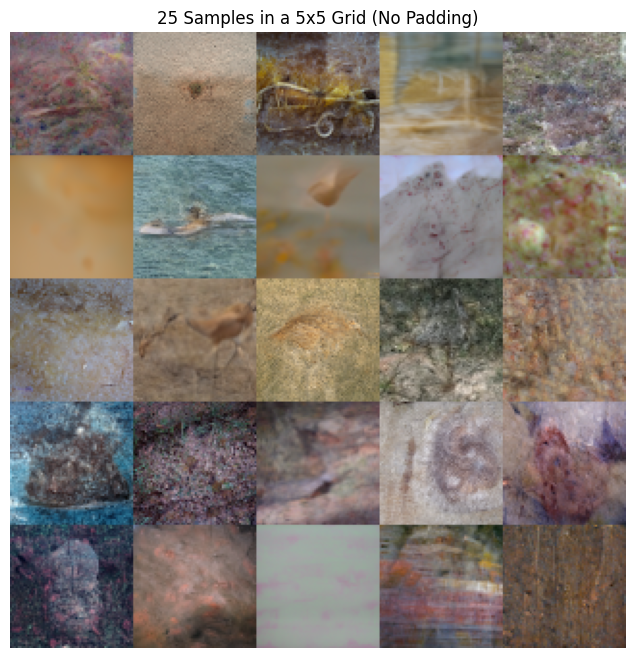

In [3]:
# (b) 모델로 샘플링 (배치 입력)
(sampled_ecp, hist2), _ = diffusion.sample_image(x, diffusion.model, ecp=True)

# (c) [-1,1] → [0,1] 범위 변환
sampled = inverse_data_transform(config, sampled_ecp)

# (d) 5x5 그리드, padding=0 => 여백 없이
grid = vutils.make_grid(sampled, nrow=5, padding=0)

# (e) matplotlib 시각화
grid_np = grid.permute(1, 2, 0).cpu().numpy()
grid_np = np.clip(grid_np, 0, 1)

plt.figure(figsize=(8,8))
plt.imshow(grid_np)
plt.axis('off')
plt.title("25 Samples in a 5x5 Grid (No Padding)")
plt.show()


In [7]:
torch.allclose(sampled_x, sampled_ecp)

True

In [5]:
for i, (h1, h2) in enumerate(zip(hist1, hist2)):
    print(i, torch.allclose(h1, h2))

0 True
1 True
2 True
3 True
4 True
